In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from scipy.stats import pearsonr
from pandas.plotting import scatter_matrix
%matplotlib inline

## Getting the columns and building a dtype dictionary

In [3]:
columns = pd.read_csv('/Volumes/thesis-data/main.csv', nrows=1).columns

In [4]:
[c for c in columns]

['100x',
 '10x',
 '2x',
 '5x',
 'ACTIVITY',
 'ACUITY',
 'ADMDATE',
 'ADM_MET',
 'ADM_SOU',
 'AMIPrim',
 'AMISec',
 'Age',
 'AsthmaPrim',
 'AsthmaSec',
 'BLD',
 'Bench_Period',
 'BldPrim',
 'BldSec',
 'BurnsPrim',
 'BurnsSec',
 'C.DIFF',
 'CC_LOS',
 'CHDPrim',
 'CHDSec',
 'CHFPrim',
 'CHFSec',
 'CNST',
 'COND_FLG',
 'COST',
 'CRIT',
 'CTDPrim',
 'CTDSec',
 'CVAPrim',
 'CVASec',
 'CanPrim',
 'CanSec',
 'CancerPrim',
 'CancerSec',
 'CerebrovascularPrim',
 'CerebrovascularSec',
 'ChronPainPrim',
 'ChronPainSec',
 'DC',
 'DIAG_NO',
 'DIAG_NO_WEI',
 'DIRECT',
 'DISCDATE',
 'DIS_DES',
 'DIS_MET',
 'DOM_LEVEL',
 'DOM_PROC',
 'DRUG',
 'DRUG_CHEMO',
 'DUMMY_TRUST',
 'DayofMainProc',
 'Dayofweek',
 'DemPrim',
 'DemSec',
 'DentPrim',
 'DentSec',
 'DiabPrim',
 'DiabSec',
 'DiabcompPrim',
 'DiabcompSec',
 'DiabetesPrim',
 'DiabetesSec',
 'EL',
 'EMER',
 'ENDO',
 'ENDO_TIME',
 'EPISODE_END',
 'EPISODE_ID',
 'EPISODE_ST',
 'EndocPrim',
 'EndocSec',
 'GUPrim',
 'GUSec',
 'GastroPrim',
 'GastroSec',
 'G

In [5]:
x = {'ADM_MET': 'object', 'DIS_MET': 'object', 'ADM_SOU': 'object',
    'MAIN_SPEC': 'object', 'NON_NHS_FLAG': 'object', 
    'OPCS_12': 'object', 'OPCS_13': 'object', 'DIAG_NO': 'int', 
    'PROC_NO': 'int', 'Age': 'int', 'DayofMainProc': 'object', 
    'SEX': 'object', 'consultant': 'object', 'end_ward': 'object', 
    'pasid': 'object', 'practice_code': 'object', 'procedure_code': 'object', 
    'site1': 'object', 'south_north': 'object', 'start_ward': 'object', 
    'end_ward': 'object', '100x': 'object', '10x': 'object', '5x': 'object', 
    '2x': 'object', 'ACTIVITY': 'object', 'C.DIFF': 'object', 
    'MRSA': 'object', 'Obese': 'object', 'NON_NHS_FLG': 'object', 
    'SPECIALTY': 'object', 'ACUITY': 'object', 'SS_CODE': 'object', 
    'WIP_FLG': 'object', 'SPELL_FLG': 'object', 'INTERNAL_ID': 'object'}

primsec = [col for col in columns if col.endswith('Prim') or col.endswith('Sec') or col.endswith('.1')]
y = {col: 'object' for col in primsec}

dtype_dict = {**x, **y}
dates = ['Bench_Period', 'Period', 'ADMDATE', 'DISCDATE', 'EPISODE_ST', 'EPISODE_END', 'procedure_date_dt']

## Reading in the whole dataset

In [6]:
%%time
chunksize = 350000
chunks = []
for chunk in pd.read_csv('/Volumes/thesis-data/main.csv', 
                         parse_dates=dates, dtype=dtype_dict, 
                         chunksize=chunksize):
    chunks.append(chunk)

df = pd.concat(chunks)

CPU times: user 3min 24s, sys: 11.7 s, total: 3min 36s
Wall time: 3min 37s


#### We have 2,447,475 episodes described by 259 attributes of which there are 865,430 individual patients and separate spells:

In [7]:
df.shape, df.PATIENT_ID.nunique(), df.SPELL_ID.nunique()

((2447475, 259), 865430, 1946597)

#### Note that in this dataset there are a number of categorical attributes with a large range of values. For instance, we have:
- 1082 GP practices
- 1468 HRGs (Healthcare Resource Groups)
- 7747 primary diagnoses (ICD10)
- 4751 primary procedures (OPCS10)

In [8]:
df.practice_code.nunique(), df.HRG.nunique(), df.ICD10.nunique(), df.OPCS4.nunique()

(1082, 1468, 7747, 4751)

#### So, we will reduce our dataset's attributes to include:
- personal identifiers (IDs, sex, age, origin, etc.)
- cost components
- non-specific clinical attributes (number of diagnoses, length of stay, HRG subchapter, obesity, admission method, elective/non-elective, etc.)

#### We will also remove specific clinical attributes such as:
- diagnosis codes
- particular HRGs
- procedure codes
- comorbidities

From this reduced dataset, we will carry out some initial descriptive data analysis that can be used for some elementary statistical inference later on. Obviously, work is needed to reduce the number of categorical values by means of clustering or in the case of GP practices, say, we could group them by their locality after they are decoded. This grouping would also make for a nice collection of graphs in the future using `geopandas`.

In [9]:
HRG_OPCS_ICD_Prog_cols = ['HRG'] + [col for col in columns if col.startswith('OPCS_') or col.startswith('ICD_') or col.startswith('Programme')]
severity = ['2x', '5x', '10x', '100x']

undesired_cols = ['LOAD_DATE'] + HRG_OPCS_ICD_Prog_cols + severity + primsec

In [10]:
costs = ['NetCost', 'CRIT', 'MED', 'WARD', 'BLD',
         'PATH', 'PROS', 'IMG', 'PHAR', 'OVH']

# Summative statistics

In [11]:
pd.set_option('max_columns', 125)
pd.set_option('max_rows', 200)

In [12]:
data = df.groupby(['PATIENT_ID', 'SPELL_ID'], as_index=True)

In [13]:
data = data[['Bench_Period', 'LOS', 'PROC_NO', 'DIAG_NO'] + costs]

In [14]:
data = data.sum()

In [14]:
df.Age.describe()

count    2.447475e+06
mean     5.395587e+01
std      2.583542e+01
min      0.000000e+00
25%      3.300000e+01
50%      5.900000e+01
75%      7.500000e+01
max      1.090000e+02
Name: Age, dtype: float64

In [101]:
data.describe()

,LOS,PROC_NO,DIAG_NO,NetCost,CRIT,MED,WARD,BLD,PATH,PROS,IMG,PHAR,OVH
count,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06,1.947156e+06
mean,3.517798e+00,1.896260e+00,4.926303e+00,1.744176e+03,9.239848e+01,3.473056e+02,4.975510e+02,2.066881e+00,3.626678e+01,4.070328e+01,3.272708e+01,3.051369e+01,3.551482e+02
std,8.689961e+00,2.205943e+00,6.927091e+00,3.195509e+03,1.338350e+03,7.419361e+02,1.240424e+03,3.719332e+01,1.359201e+02,3.436083e+02,1.437745e+02,8.699462e+01,7.362845e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,4.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,3.473373e+02,0.000000e+00,4.445000e+01,1.033000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.260000e+00,8.486000e+01
50%,1.000000e+00,1.000000e+00,3.000000e+00,7.473911e+02,0.000000e+00,1.306865e+02,1.420900e+02,0.000000e+00,4.640000e+00,0.000000e+00,8.000000e-02,7.250000e+00,1.394900e+02
75%,2.000000e+00,3.000000e+00,6.000000e+00,1.863420e+03,0.000000e+00,3.754300e+02,4.633700e+02,1.500000e-01,3.192000e+01,0.000000e+00,1.093096e+01,2.624000e+01,3.211200e+02
max,3.660000e+03,7.000000e+01,4.550000e+02,3.691689e+05,2.500006e+05,1.164499e+05,2.038541e+05,1.376871e+04,7.000812e+04,3.393070e+04,4.670866e+04,2.508773e+04,1.064286e+05


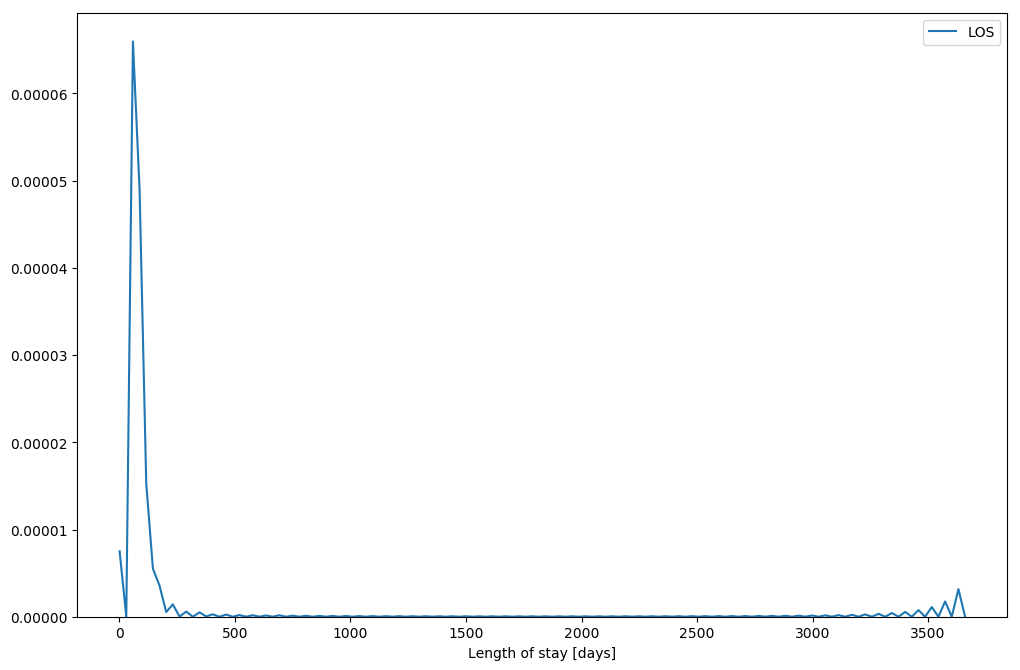

In [16]:
plt.figure(figsize=(12,8), dpi=100)
ax = sns.kdeplot(data.LOS)
plt.xlabel('Length of stay [days]')
# plt.savefig('LOS-kde.pdf');

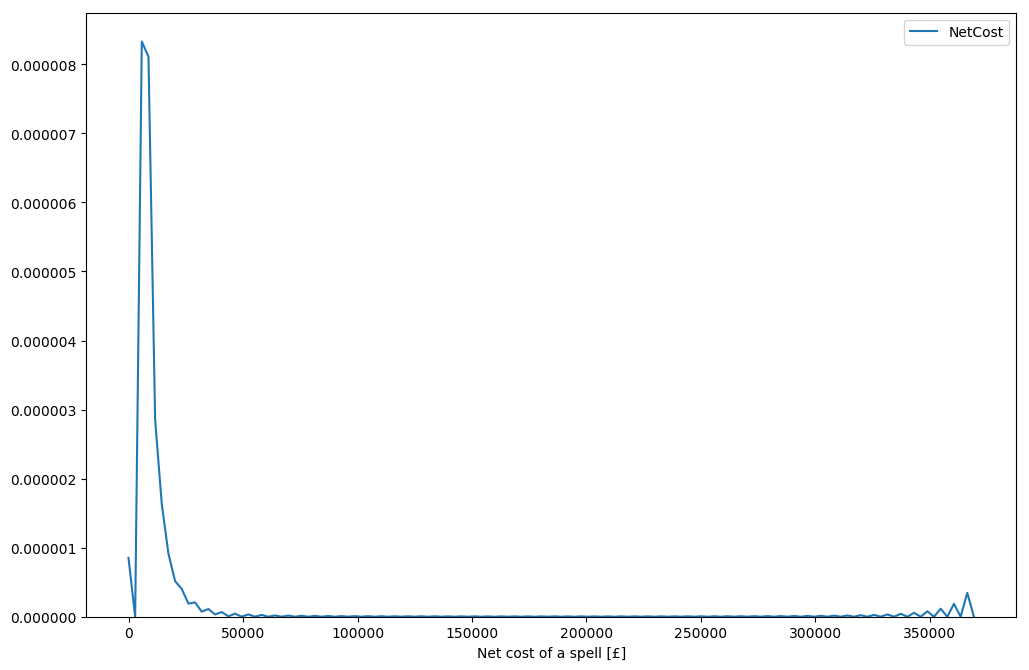

In [17]:
plt.figure(figsize=(12,8), dpi=100)
ax = sns.kdeplot(data.NetCost)
plt.xlabel('Net cost of a spell [£]')
# plt.savefig('NetCost-kde.pdf');

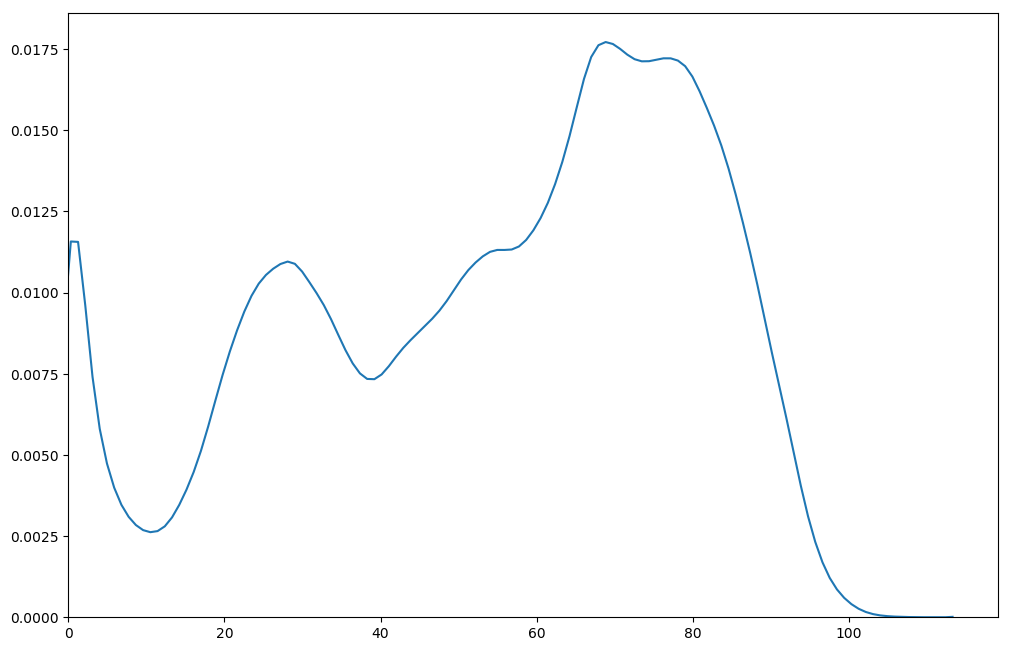

In [15]:
plt.figure(figsize=(12,8), dpi=100)
sns.kdeplot(df.Age, legend=False)
plt.xlim(0)
plt.savefig('Age-kde.pdf');

In [143]:
df.site1.unique()

array(['PCH', 'RGH', nan], dtype=object)

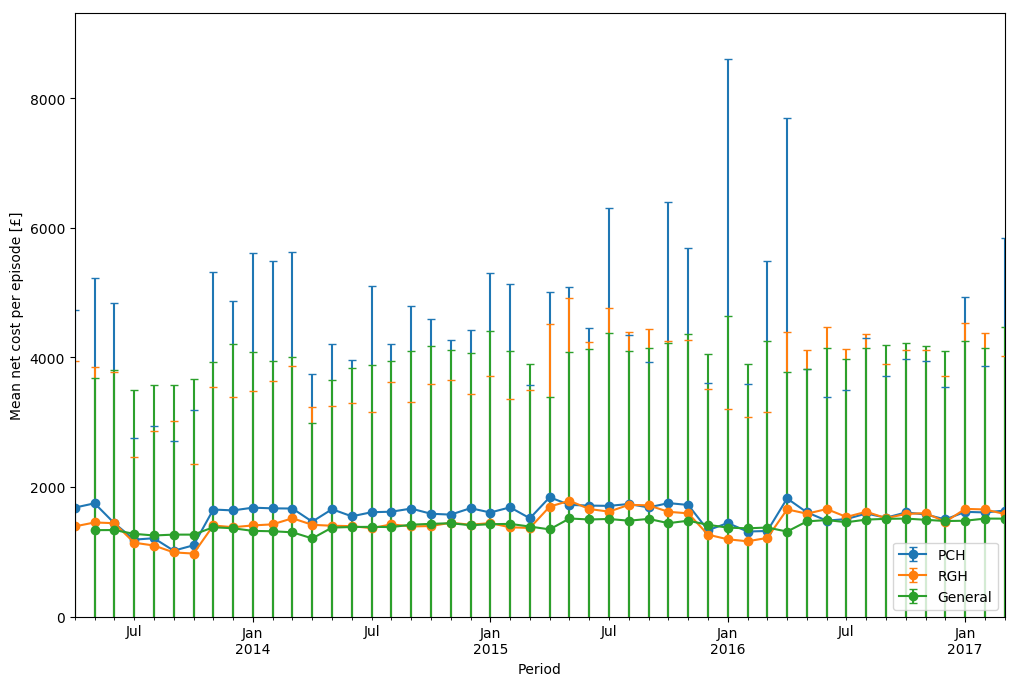

In [19]:
plt.figure(figsize=(12,8), dpi=100)

pch = df[df.site1=='PCH'].groupby('Period').NetCost
pch.mean().plot(yerr=pch.std(), fmt='o-', capsize=3, label='PCH')
rgh = df[df.site1=='RGH'].groupby('Period').NetCost
rgh.mean().plot(yerr=rgh.std(), fmt='o-', capsize=3, label='RGH')
general = df[df.Period > datetime.date(2013, 4, 1)].groupby('Period').NetCost
general.mean().plot(yerr=general.std(), fmt='o-', capsize=3, label='General')

plt.ylabel('Mean net cost per episode [£]')
plt.ylim(0)
plt.legend(loc='lower right')
plt.savefig('Mean-NetCost-by-site.pdf');

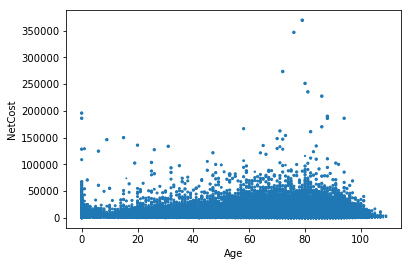

In [131]:
df.plot.scatter(x='Age', y='NetCost', s=np.log(df['LOS']));

# Correlation

In [150]:
data.corr().round(3)

,LOS,PROC_NO,DIAG_NO,NetCost,CRIT,MED,WARD,BLD,PATH,PROS,IMG,PHAR,OVH
LOS,1.000,0.188,0.461,0.808,0.215,0.483,0.816,0.138,0.418,0.034,0.260,0.625,0.848
PROC_NO,0.188,1.000,0.138,0.334,0.112,0.339,0.178,0.081,0.207,0.108,0.272,0.172,0.236
DIAG_NO,0.461,0.138,1.000,0.407,0.099,0.206,0.427,0.102,0.292,-0.002,0.216,0.377,0.442
NetCost,0.808,0.334,0.407,1.000,0.273,0.751,0.863,0.177,0.480,0.217,0.308,0.673,0.910
CRIT,0.215,0.112,0.099,0.273,1.000,0.443,0.059,0.110,0.383,0.008,0.139,0.244,0.273
MED,0.483,0.339,0.206,0.751,0.443,1.000,0.435,0.165,0.384,0.135,0.188,0.446,0.594
WARD,0.816,0.178,0.427,0.863,0.059,0.435,1.000,0.108,0.350,0.055,0.229,0.585,0.853
BLD,0.138,0.081,0.102,0.177,0.110,0.165,0.108,1.000,0.165,0.022,0.050,0.124,0.149
PATH,0.418,0.207,0.292,0.480,0.383,0.384,0.350,0.165,1.000,0.014,0.223,0.382,0.431
PROS,0.034,0.108,-0.002,0.217,0.008,0.135,0.055,0.022,0.014,1.000,0.058,0.029,0.073


In [21]:
data.cov()

,LOS,PROC_NO,DIAG_NO,NetCost,CRIT,MED,WARD,BLD,PATH,PROS,IMG,PHAR,OVH
LOS,75.515429,3.606509,27.736100,2.242748e+04,2.505585e+03,3.116718e+03,8.799528e+03,44.703087,493.823136,101.783446,324.914989,472.588616,5.424049e+03
PROC_NO,3.606509,4.866185,2.104503,2.354177e+03,3.292716e+02,5.547314e+02,4.866564e+02,6.672589,62.157833,81.642412,86.353201,33.009608,3.837349e+02
DIAG_NO,27.736100,2.104503,47.984588,9.018087e+03,9.154127e+02,1.058223e+03,3.665729e+03,26.359334,274.923604,-5.019147,215.504405,227.112387,2.252613e+03
NetCost,22427.476701,2354.177018,9018.087434,1.021128e+07,1.166633e+06,1.780035e+06,3.420762e+06,21022.109747,208405.678363,238511.110726,141683.686843,187145.151915,2.140849e+06
CRIT,2505.584875,329.271579,915.412704,1.166633e+06,1.791180e+06,4.403666e+05,9.780285e+04,5458.333079,69740.905057,3795.423659,26795.960809,28406.518466,2.691477e+05
MED,3116.717729,554.731403,1058.222829,1.780035e+06,4.403666e+05,5.504692e+05,3.998860e+05,4560.428573,38712.426420,34310.039215,20016.716441,28793.218902,3.246163e+05
WARD,8799.528355,486.656351,3665.728629,3.420762e+06,9.780285e+04,3.998860e+05,1.538652e+06,4972.804933,58985.193833,23465.534443,40904.423065,63112.121839,7.794643e+05
BLD,44.703087,6.672589,26.359334,2.102211e+04,5.458333e+03,4.560429e+03,4.972805e+03,1383.343332,834.081383,280.005011,268.805927,401.580460,4.081700e+03
PATH,493.823136,62.157833,274.923604,2.084057e+05,6.974091e+04,3.871243e+04,5.898519e+04,834.081383,18474.269042,644.062147,4365.188811,4518.195982,4.314533e+04
PROS,101.783446,81.642412,-5.019147,2.385111e+05,3.795424e+03,3.431004e+04,2.346553e+04,280.005011,644.062147,118066.631388,2876.317896,875.387433,1.855245e+04


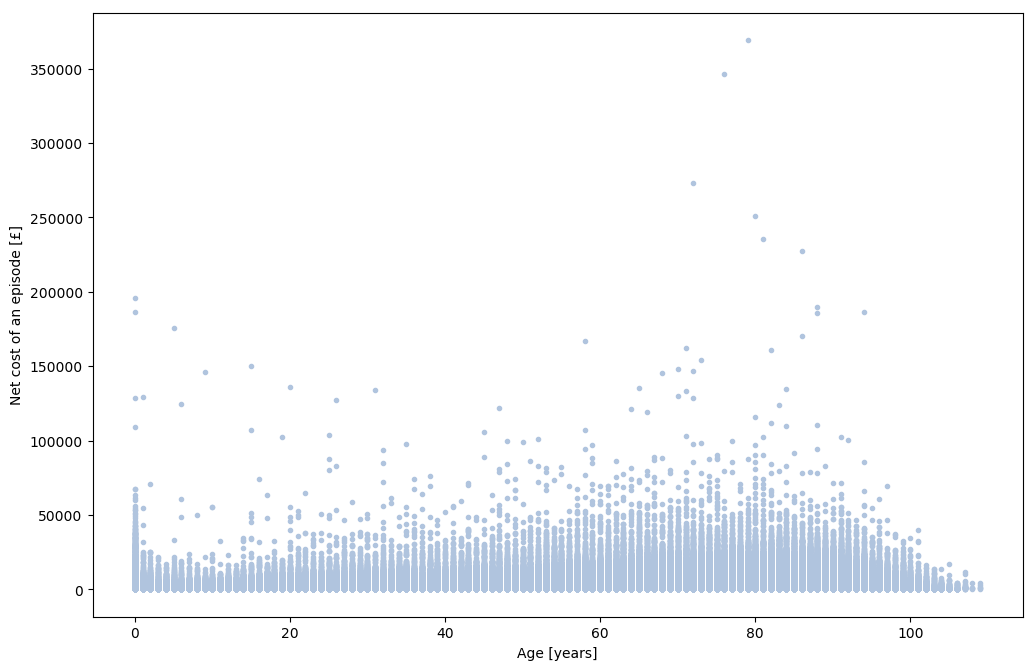

In [102]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(df.Age, df.NetCost, 'b.', color='lightsteelblue')
plt.xlabel('Age [years]')
plt.ylabel('Net cost of an episode [£]')
plt.savefig('Age-NetCost.pdf');

# Diabetes

In [21]:
diabetes_prim = (df.DiabetesPrim == '1.0')
diabetes_sec = (df.DiabetesSec == '1.0')
no_diabetes = (df.DiabetesPrim == '0.0') & (df.DiabetesSec == '0.0')

In [22]:
prim = len(df[diabetes_prim])
sec = len(df[diabetes_sec])
none = len(df[no_diabetes])
total = len(df)

In [23]:
percentages = [a / total * 100 for a in [prim, sec, none]]

In [24]:
percentages

[0.5392496348277307, 10.255589944738967, 89.2051604204333]

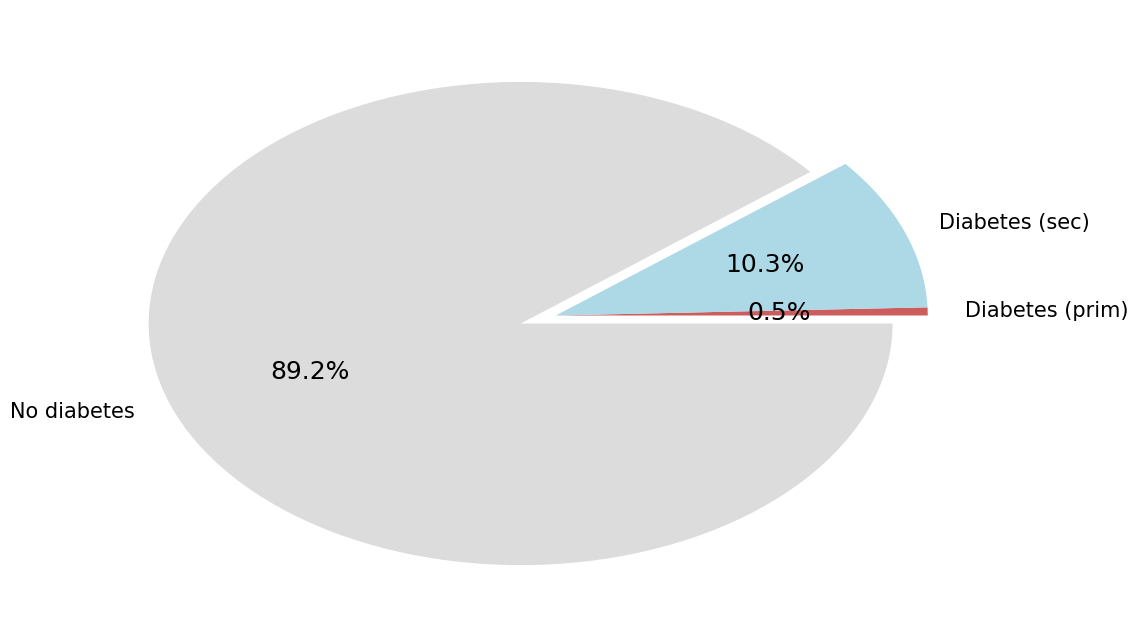

In [113]:
plt.figure(figsize=(12,8), dpi=100)
patches, texts, autotexts = plt.pie(percentages, 
                                    labels=['Diabetes (prim)', 'Diabetes (sec)', 'No diabetes'], 
                                    explode=[0.0, 0.0, 0.1], 
                                    autopct='%1.1f%%', 
                                    colors=['indianred', 'lightblue', 'gainsboro']
                                   )
for i in range(len(percentages)):
    texts[i].set_fontsize(15)
    autotexts[i].set_fontsize(18)
plt.savefig('Diabetes-pie-chart.pdf');

In [25]:
diabetes = df[diabetes_prim | diabetes_sec]

In [147]:
diabetes.groupby(['PATIENT_ID', 'SPELL_ID'])[['Bench_Period', 'LOS', 'PROC_NO', 'DIAG_NO'] + costs].sum().describe()

,LOS,PROC_NO,DIAG_NO,NetCost,CRIT,MED,WARD,BLD,PATH,PROS,IMG,PHAR,OVH
count,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000,171274.000000
mean,6.425476,2.054556,11.215911,2656.442813,152.782283,443.665992,846.554610,4.241639,64.244607,54.461077,57.973359,58.459907,580.281773
std,11.735501,2.586548,10.498250,4164.125553,1543.920272,825.346534,1679.104644,48.041927,176.085880,434.856479,174.074030,124.683185,985.145823
min,1.000000,0.000000,1.000000,10.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,5.000000,491.785176,0.000000,67.714250,59.638148,0.000000,0.680000,0.000000,0.000000,3.810000,107.559655
50%,2.000000,2.000000,8.000000,1231.218378,0.000000,193.410000,273.943899,0.000000,20.130000,0.000000,0.980000,16.240000,230.323698
75%,7.000000,3.000000,13.000000,3113.810080,0.000000,478.930303,989.112500,0.510000,71.034062,0.000000,38.258247,71.780124,665.510000
max,678.000000,43.000000,423.000000,273450.302400,193076.194624,58673.470000,173963.466100,5757.190000,28621.004411,28955.990000,8097.569983,14812.142079,57647.286640


In [148]:
diabetes.Age.describe()

count    264201.000000
mean         69.620599
std          15.593737
min           0.000000
25%          62.000000
50%          72.000000
75%          81.000000
max         107.000000
Name: Age, dtype: float64

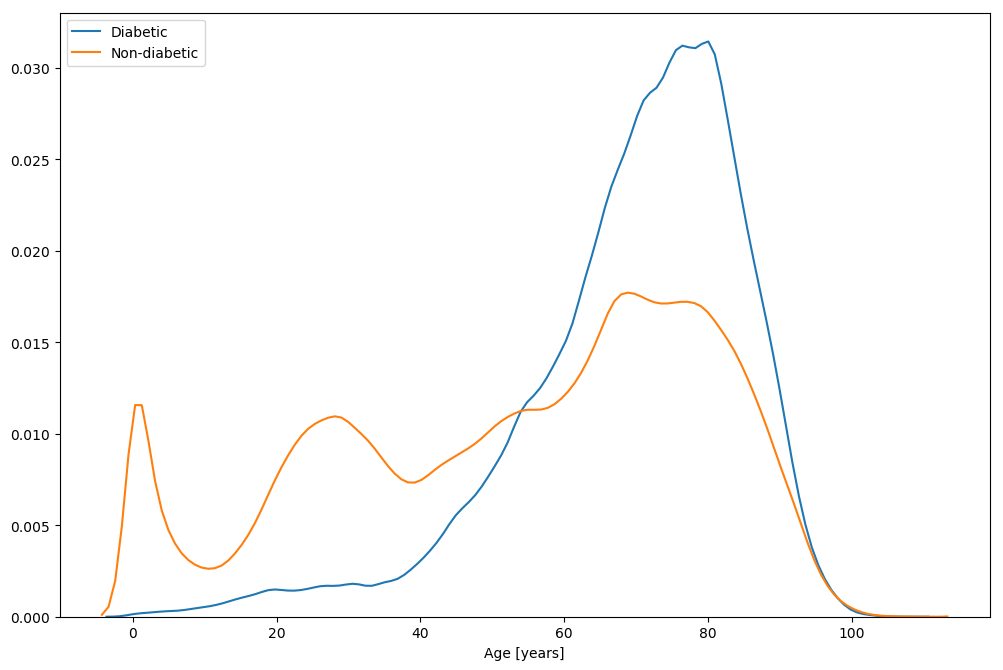

In [27]:
plt.figure(figsize=(12,8), dpi=100)
sns.kdeplot(diabetes.Age, legend=False, label='Diabetic')
sns.kdeplot(df.Age, legend=False, label='Non-diabetic')
plt.xlabel('Age [years]')
plt.savefig('Diabetes-Age-kde.pdf')
plt.legend(loc='upper left');

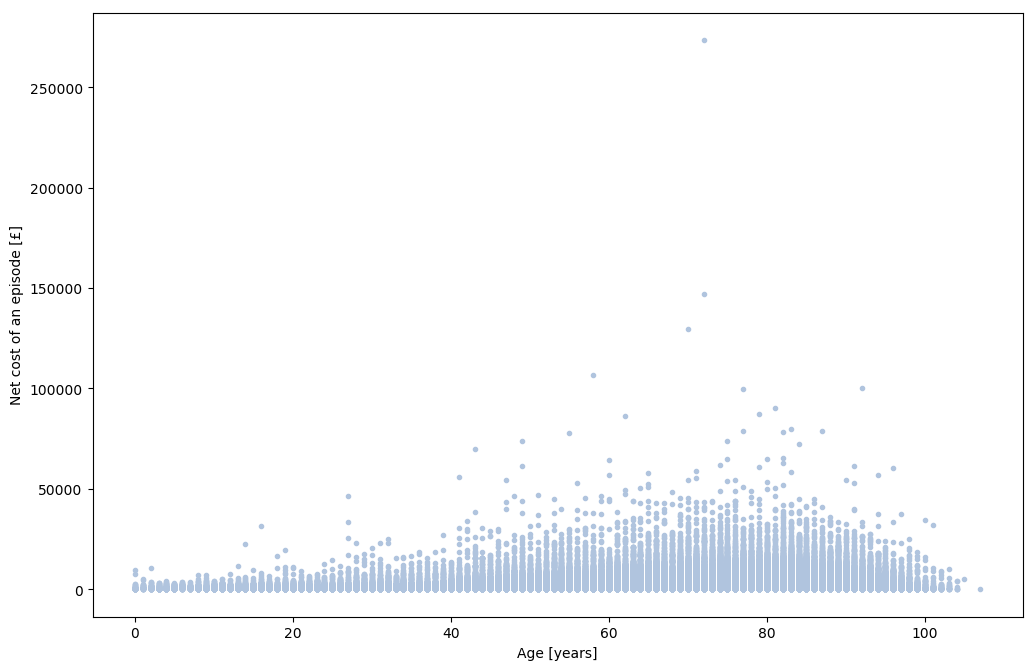

In [103]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(diabetes.Age, diabetes.NetCost, 'b.', color='lightsteelblue')
plt.xlabel('Age [years]')
plt.ylabel('Net cost of an episode [£]')
plt.savefig('Diabetes-Age-NetCost.pdf');